In [1]:
#-------------------------------------------
#|                                         |
#|  Name: Carles Roch i Carceller          |
#|  Code: SDP for RNG certification        |
#|        with MCD observed confidence.    |
#|        Noncontextual and quantum        |
#|        theories are compared.           |
#|        Dual SDP.                        |
#|                                         |
#-------------------------------------------

In [2]:
# Import packages.
import cvxpy as cp
from cvxopt import matrix, solvers
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import math
import time
from pylab import *
from qutip import *
#import imageio

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
import mosek
import cvxopt
#from sympy.solvers import solve
#from sympy import Symbol

import numpy as np
import time
import cvxpy as cp
from cvxpy import *
from cvxopt import matrix, solvers
#from sympy import symbols, solve
#from sympy import *
import csv
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
import mosek
import cvxopt




#Set initial (global) parameters

#Prior probabilities of sending each state
p1 = 0.5
p2 = 1.0-p1
p = [p1,p2]

r_vec = [0.0,0.3]

#Number of code samples
N=100

#Relation between eta0 and eta2
cte = 10000.0

#Define the eta1 vector (probability of measuring rho1)
eta1vec = np.linspace(1.0/N,(N-1.0)/N,N)

olaps = [0.4, 0.5, 0.6, 0.7]

#Define the delta function
def deltaF(x,n):
    if x == n:
        return 1.0
    else:
        return 0.0

#Sigma Matrices

sigmax = np.array([[0.0,1.0],[1.0,0.0]])
sigmay = np.array([[0.0,-1.0j],[1.0j,0.0]])
sigmaz = np.array([[1.0,0.0],[0.0,-1.0]])

In [3]:
#Start by finding the maximum confindence of discriminating two states
#Define the vectors where we will store all the probabilties and Confidences
C_1 = np.zeros((2,4,2,N))
C_2 = np.zeros((2,4,2,N))
P_12 = np.zeros((2,4,2,N))
P_21 = np.zeros((2,4,2,N))
P_11 = np.zeros((2,4,2,N))
P_22 = np.zeros((2,4,2,N))
P_01 = np.zeros((2,4,2,N))
P_02 = np.zeros((2,4,2,N))
eta0 = np.zeros((2,4,2,N))

for u in range(0,2):
    
    for q in range(0,4):

        #Code execution time monitoring variable
        remaining_time = 0.0

        #Overlap we are working with
        c12 = olaps[q]
        d = np.sqrt(c12)
        r = r_vec[u]

        #States
        v1 = np.array([[1.0,0.0]])
        v2 = np.array([[d,np.sqrt(1.0-d**2.0)]])

        maxmix_NC = (1.0/2.0)*np.array([[1.0-c12,c12],[c12,1.0-c12]])
        maxmix_Q = (1.0/2.0)*np.identity(2)

        rho = []
        #Density matrices
        rho.append((1.0-r)*np.kron(np.transpose(v1),v1)+r*maxmix_Q) #rho[0]=rho1
        rho.append((1.0-r)*np.kron(np.transpose(v2),v2)+r*maxmix_Q) #rho[1]=rho2

        mu = []
        mu.append((1.0-r)*np.array([[1.0-c12,c12],[0.0,0.0]])+r*maxmix_NC)
        mu.append((1.0-r)*np.array([[0.0,c12],[0.0,1.0-c12]])+r*maxmix_NC)

        rhoavg = p1*rho[0] + p2*rho[1]  #Averaged density matrix of the whole ensemble
        muavg = p1*mu[0] + p2*mu[1]


        for i in range(0,len(eta1vec)):
            start = time.process_time()
            print(f'{round(float(i)/float(N)*100.0,1)}%, reimaining time: {round(remaining_time,1)} s\r', end="")

            eta1 = eta1vec[i]

            #Measures as POVM elements, which are variables in the optimisation problem
            M1_NC = cp.Variable((2,2),nonneg=True)
            M2_NC = cp.Variable((2,2),nonneg=True)
            M0_NC = cp.Variable((2,2),nonneg=True)

            M1_Q = cp.Variable((2,2),PSD=True)
            M2_Q = cp.Variable((2,2),PSD=True)
            M0_Q = cp.Variable((2,2),PSD=True)

            eta_2Q = cp.trace(rhoavg @ M2_Q)
            eta_0Q = cp.trace(rhoavg @ M0_Q)

            eta_2NC = cp.trace(muavg.T @ M2_NC)
            eta_0NC = cp.trace(muavg.T @ M0_NC)

            #Constraints of the optimisation problem
            constraintsNC = [M0_NC+M1_NC+M2_NC==np.ones((2,2)),  #M0 must be PSD (M1 and M2 are already defined as PSD)
                             cp.trace(muavg.T @ M1_NC)==eta1, #Eta1 must be the probability of measuring rho1
                             eta_0NC == cte*eta_2NC, #, #0.5*(1.0-d**2.0) 
                             M0_NC[0][0] + M0_NC[1][1] == M0_NC[1][0] + M0_NC[0][1] ,
                             M1_NC[0][0] + M1_NC[1][1] == M1_NC[1][0] + M1_NC[0][1] ,
                             M2_NC[0][0] + M2_NC[1][1] == M2_NC[1][0] + M2_NC[0][1]
                          ]

            constraintsQ = [M0_Q+M1_Q+M2_Q==np.identity(2),  #M0 must be PSD (M1 and M2 are already defined as PSD)
                            cp.trace(rhoavg @ M1_Q)==eta1, #Eta1 must be the probability of measuring rho1
                            eta_0Q == cte*eta_2Q#0.5*(1.0-d**2.0)
                          ]

            #Confidence function of measuring rho1
            C1_NC = p1*cp.trace(mu[0].T @ M1_NC)/eta1
            C1_Q = p1*cp.trace(rho[0] @ M1_Q)/eta1

            #The conidence C1 is the object function
            obj_Q = cp.Maximize(C1_Q)
            obj_NC = cp.Maximize(C1_NC)

            #Define and solve the problem
            prob_Q = cp.Problem(obj_Q,constraintsQ)
            prob_Q.solve(solver='MOSEK')

            prob_NC = cp.Problem(obj_NC,constraintsNC)
            prob_NC.solve()

            #Store the results in teh vectors defined in the beginning
            if M1_NC.value is None or M2_NC.value is None: #If the optimisation problem found no solution, store None values

                C_1[u][q][0][i] = None
                C_2[u][q][0][i] = None
                P_12[u][q][0][i] = None
                P_21[u][q][0][i] = None
                P_11[u][q][0][i] = None
                P_22[u][q][0][i] = None
                P_01[u][q][0][i] = None
                P_02[u][q][0][i] = None

            else: #IF the optimisaiton problem found solutions, store the following probabilities

                C_1[u][q][0][i] = p1*np.trace(np.dot(mu[0].T,M1_NC.value))/eta1
                C_2[u][q][0][i] = p2*np.trace(np.dot(mu[1].T,M2_NC.value))/(np.trace(np.dot(muavg.T,M2_NC.value)))
                P_12[u][q][0][i] = np.trace(np.dot(mu[1].T,M1_NC.value))
                P_21[u][q][0][i] = np.trace(np.dot(mu[0].T,M2_NC.value))
                P_11[u][q][0][i] = np.trace(np.dot(mu[0].T,M1_NC.value))
                P_22[u][q][0][i] = np.trace(np.dot(mu[1].T,M2_NC.value))
                P_01[u][q][0][i] = np.trace(np.dot(mu[0].T,M0_NC.value))
                P_02[u][q][0][i] = np.trace(np.dot(mu[1].T,M0_NC.value))
                eta0[u][q][0][i] = (np.trace(np.dot(muavg.T,M0_NC.value)))

            if M1_Q.value is None or M2_Q.value is None: #If the optimisation problem found no solution, store None values

                C_1[u][q][1][i] = None
                C_2[u][q][1][i] = None
                P_12[u][q][1][i] = None
                P_21[u][q][1][i] = None
                P_11[u][q][1][i] = None
                P_22[u][q][1][i] = None
                P_01[u][q][1][i] = None
                P_02[u][q][1][i] = None

            else: #IF the optimisaiton problem found solutions, store the following probabilities

                C_1[u][q][1][i] = p1*np.trace(np.dot(rho[0],M1_Q.value))/eta1
                C_2[u][q][1][i] = p2*np.trace(np.dot(rho[1],M2_Q.value))/(np.trace(np.dot(rhoavg,M2_Q.value)))
                P_12[u][q][1][i] = np.trace(np.dot(rho[1],M1_Q.value))
                P_21[u][q][1][i] = np.trace(np.dot(rho[0],M2_Q.value))
                P_11[u][q][1][i] = np.trace(np.dot(rho[0],M1_Q.value))
                P_22[u][q][1][i] = np.trace(np.dot(rho[1],M2_Q.value))
                P_01[u][q][1][i] = np.trace(np.dot(rho[0],M0_Q.value))
                P_02[u][q][1][i] = np.trace(np.dot(rho[1],M0_Q.value))
                eta0[u][q][1][i] = (np.trace(np.dot(rhoavg,M0_Q.value)))

            #Code execution time monitoring variable
            end = time.process_time()
            total_time = (end-start)*N
            remaining_time = (end-start)*(N-i)





In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=2)  # fontsize of the figure title


In [5]:
#MCM single state
C_0_vec = np.zeros(N)

r = 0.7
vec = np.linspace(0.0,1.0,N)
d = np.sqrt(0.4)

for i in range(N):
    eta0 = vec[i]
    if eta0 <= (1.0-(r*d)**2.0)/2.0:
        C = 0.5*(1.0+r*np.sqrt(1.0-d**2.0)/np.sqrt(1.0-r**2.0*d**2.0))
    elif eta0 >= (1.0+(r*d)**2.0)/2.0:
        C = 0.5*(1.0+r*np.sqrt(1.0-d**2.0)/(np.sqrt(1.0-(r*d)**2.0))*(1.0/eta0-1.0))
    else:
        C = 0.5*(1.0+np.sqrt(1.0-d**2.0)*np.sqrt((r*d)**2.0-(1.0-2.0*eta0)**2.0)/(2.0*eta0*d))

    C_0_vec[i] = C

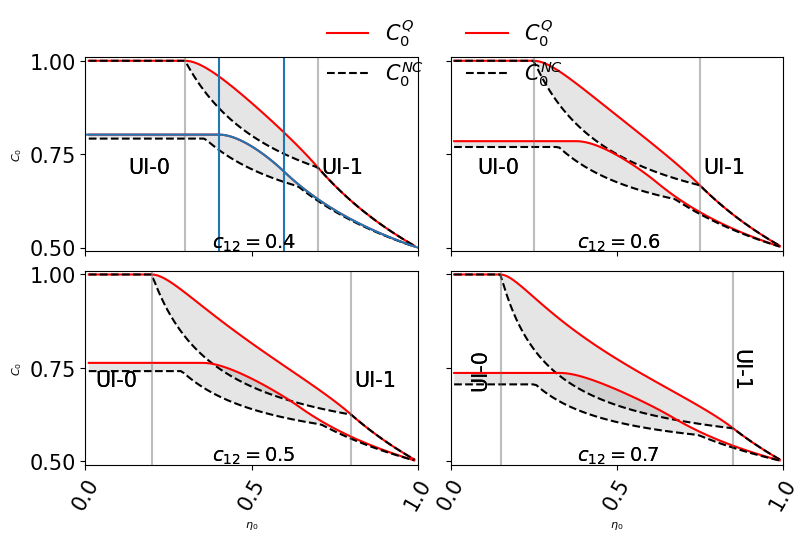

In [6]:
fig, ax = plt.subplots(2,2,figsize=(9,6),sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
#fig.tight_layout()



plt.ylim(0.49,1.01)
plt.xlim(0.0,1.0)
ax[1,0].set_xlabel(r'$\eta_{0}$')
ax[1,1].set_xlabel(r'$\eta_{0}$')
ax[1,0].set_ylabel(r'$C_{0}$')
ax[0,0].set_ylabel(r'$C_{0}$')
ax[1,0].set_xticks([0.0,0.5,1.0])
ax[1,0].set_yticks([0.5,0.75,1.0])

ax[1,0].tick_params(axis='x', rotation=60)
ax[1,1].tick_params(axis='x', rotation=60)

for u in range(0,2):

    ax[0,0].plot(eta1vec,C_1[u][0][1],c='red',label=r'$C_{0}^{Q}$',ls='-')
    ax[0,0].plot(eta1vec,C_1[u][0][0],c='black',label=r'$C_{0}^{NC}$',ls='--')
    ax[0,0].fill_between(eta1vec, C_1[u][0][1], C_1[u][0][0], where=C_1[u][0][1] >= C_1[u][0][0], facecolor='gray', alpha=0.2)
    ax[0,0].axvline((1.0/2.0)*(1.0-olaps[0]),c='gray', alpha=0.3)
    ax[0,0].axvline((1.0/2.0)*(1.0+olaps[0]),c='gray', alpha=0.3)
    ax[0,0].text((1.0/2.0)*(1.0-olaps[0])-0.17,0.7,'UI-0',size=15,rotation=0)
    ax[0,0].text((1.0/2.0)*(1.0+olaps[0])+0.01,0.7,'UI-1',size=15,rotation=0)

    ax[0,1].plot(eta1vec,C_1[u][1][1],c='red',label=r'$C_{0}^{Q}$',ls='-')
    ax[0,1].plot(eta1vec,C_1[u][1][0],c='black',label=r'$C_{0}^{NC}$',ls='--')
    ax[0,1].fill_between(eta1vec, C_1[u][1][1], C_1[u][1][0], where=C_1[u][1][1] >= C_1[u][1][0], facecolor='gray', alpha=0.2)
    ax[0,1].axvline((1.0/2.0)*(1.0-olaps[1]),c='gray', alpha=0.3)
    ax[0,1].axvline((1.0/2.0)*(1.0+olaps[1]),c='gray', alpha=0.3)
    ax[0,1].text((1.0/2.0)*(1.0-olaps[1])-0.17,0.7,'UI-0',size=15,rotation=0)
    ax[0,1].text((1.0/2.0)*(1.0+olaps[1])+0.01,0.7,'UI-1',size=15,rotation=0)

    ax[1,0].plot(eta1vec,C_1[u][2][1],c='red',label=r'$C_{0}^{Q}$',ls='-')
    ax[1,0].plot(eta1vec,C_1[u][2][0],c='black',label=r'$C_{0}^{NC}$',ls='--')
    ax[1,0].fill_between(eta1vec, C_1[u][2][1], C_1[u][2][0], where=C_1[u][2][1] >= C_1[u][2][0], facecolor='gray', alpha=0.2)
    ax[1,0].axvline((1.0/2.0)*(1.0-olaps[2]),c='gray', alpha=0.3)
    ax[1,0].axvline((1.0/2.0)*(1.0+olaps[2]),c='gray', alpha=0.3)
    ax[1,0].text((1.0/2.0)*(1.0-olaps[2])-0.17,0.7,'UI-0',size=15,rotation=0)
    ax[1,0].text((1.0/2.0)*(1.0+olaps[2])+0.01,0.7,'UI-1',size=15,rotation=0)

    ax[1,1].plot(eta1vec,C_1[u][3][1],c='red',label=r'$C_{0}^{Q}$',ls='-')
    ax[1,1].plot(eta1vec,C_1[u][3][0],c='black',label=r'$C_{0}^{NC}$',ls='--')
    ax[1,1].fill_between(eta1vec, C_1[u][3][1], C_1[u][3][0], where=C_1[u][3][1] >= C_1[u][3][0], facecolor='gray', alpha=0.2)
    ax[1,1].axvline((1.0/2.0)*(1.0-olaps[3]),c='gray', alpha=0.3)
    ax[1,1].axvline((1.0/2.0)*(1.0+olaps[3]),c='gray', alpha=0.3)
    ax[1,1].text((1.0/2.0)*(1.0-olaps[3])-0.09,0.7,'UI-0',size=15,rotation=90)
    ax[1,1].text((1.0/2.0)*(1.0+olaps[3])-0.01,0.7,'UI-1',size=15,rotation=-90)

    ax[0,0].text(0.38,0.5,r'$c_{12}=$%1.1f' %olaps[0],size=14,rotation=0)
    ax[1,0].text(0.38,0.5,r'$c_{12}=$%1.1f' %olaps[1],size=14,rotation=0)
    ax[0,1].text(0.38,0.5,r'$c_{12}=$%1.1f' %olaps[2],size=14,rotation=0)
    ax[1,1].text(0.38,0.5,r'$c_{12}=$%1.1f' %olaps[3],size=14,rotation=0)

#ax[0,0].axhline(0.5*(1.0+(1.0-r)*np.sqrt(1.0-olaps[0])/np.sqrt(1.0-(1.0-r)**2.0*olaps[0])))


ax[1,1].legend( bbox_to_anchor=(-0.43, 2.4), loc='upper left', ncol = 2, frameon=False)
plt.gcf().subplots_adjust(bottom=0.2)

#plt.savefig('Confi_4_noisy_01.pdf')
ax[0,0].plot(vec,C_0_vec)
ax[0,0].axvline(0.5*(1.0-(r*d)**2.0))
ax[0,0].axvline(0.5*(1.0+(r*d)**2.0))


plt.show()

In [7]:
#From the MCD optimisation problem results, now we find the Probability an Eavesdropper has in guessing the
#measurement output
#We will solve at the same time two SDPs: One for the Quantum scenatrio and the other from the NonContextual.
#This code corresponds to solving the dual problem

#Define the vectors which will be plotted as results of this problem  Hmin[case][olap][N]
Hminvec = np.zeros((2,2,4,N))
GuessingProb = np.zeros((2,2,4,N))
HminvecNC = np.zeros((2,2,4,N))  #--- everything ending with 'NC' is from the NonContextual scenario
GuessingProbNC = np.zeros((2,2,4,N))

for u in range(0,2):
    for q in range(1,4):

        #Code execution time monitoring variable
        remaining_time = 0.0

        #Overlap we are working with
        c12 = olaps[q]
        d = np.sqrt(c12)
        r = r_vec[u]

        #States
        v1 = np.array([[1.0,0.0]])
        v2 = np.array([[d,np.sqrt(1.0-d**2.0)]])

        rho = []
        #Density matrices
        rho.append(np.kron(np.transpose(v1),v1)) #rho[0]=rho1
        rho.append(np.kron(np.transpose(v2),v2)) #rho[1]=rho2

        mu = []
        mu.append(np.array([[1.0-c12,c12],[0.0,0.0]]))
        mu.append(np.array([[0.0,c12],[0.0,1.0-c12]]))

        rhoavg = p1*rho[0] + p2*rho[1]  #Averaged density matrix of the whole ensemble
        muavg = p1*mu[0] + p2*mu[1]

        #Code execution time monitoring variable
        remaining_time = 0.0

        #Define the lambda1, lambda2, y and x values we will operate with as vectors
        l1vec = [0,1,2]
        l2vec = [0,1,2]
        yvec = [0,1,2]
        xvec = [0,1]

        #We will store the Dual Variable in these matrices, before solving the problem
        #H[l1][l2]
        H = [[None,None,None],
             [None,None,None],
             [None,None,None]]
        HNC = [[None,None,None],
             [None,None,None],
             [None,None,None]]

        #v[x]
        v = [None,None]
        vNC = [None,None]

        #xi
        xi = None
        xiNC = None

        #We will store the Dual Variables after solving the problem
        #H[l1][l2][eta1]
        H_final = [[[],[],[]],
             [[],[],[]],
             [[],[],[]]]
        HNC_final = [[[],[],[]],
             [[],[],[]],
             [[],[],[]]]
        #v[x][eta1]
        v_final = [[],[]]
        vNC_final = [None,None]

        #xi[eta1]
        xi_final = []
        xiNC_final = []

        for i in range(0,N):

            #Code execution time monitoring variable
            start = time.process_time()
            print(f'{round(float(i)/float(N)*100.0,1)}%, reimaining time: {round(remaining_time,1)}s\r', end="")

            #Define eta1 as an elements of the vector eta1vec defined in the beginning
            eta1 = eta1vec[i]

            #Non-contextual Confidence
            C1NC = C_1[u][q][0]

            #Define Dual Varibales
            for l1 in l1vec:
                for l2 in l2vec:
                    H[l1][l2] = cp.Variable((2,2))
                    HNC[l1][l2] = cp.Variable((2,2))

            for x in xvec:
                v[x] = cp.Variable()
                vNC[x] = cp.Variable()

            xi = cp.Variable()
            xiNC = cp.Variable()


            #Subject to -----------------------------------------------------------------------------------------
            constraints = []
            constraintsNC = [] #Non.Contextual case

            #Hermitian:
            for l1 in l1vec:
                for l2 in l2vec:
                    for y in yvec:
                        constraints.append(H[l1][l2]==H[l1][l2].H)
                        #constraintsNC.append(HNC[l1][l2]==HNC[l1][l2].H) #Non.Contextual case

            #K<=0
            for y in yvec:
                for l1 in l1vec:
                    for l2 in l2vec:
                        sumc = 0.0
                        sumcNC = 0.0
                        for x in xvec:
                            sumc = sumc + p[x]*rho[x]*(deltaF(y,l1)*deltaF(x,0)+deltaF(y,l2)*deltaF(x,1) + v[x]*deltaF(y,0) + xi)
                            sumc = sumc + H[l1][l2]-cp.trace(H[l1][l2] @ np.identity(2))*maxmix_Q

                            sumcNC = sumcNC + p[x]*mu[x].T*(deltaF(y,l1)*deltaF(x,0)+deltaF(y,l2)*deltaF(x,1) + vNC[x]*deltaF(y,0) + xiNC)
                            sumcNC = sumcNC + HNC[l1][l2]-cp.trace(HNC[l1][l2]@np.ones((2,2)))*maxmix_NC.T

                        constraints.append(sumc<<0.0)
                        #constraints.append(sumcNC<<0.0)
                        constraintsNC.append(sumcNC[0][0]<=0.0)
                        constraintsNC.append(sumcNC[0][1]<=0.0)
                        constraintsNC.append(sumcNC[1][0]<=0.0)
                        constraintsNC.append(sumcNC[1][1]<=0.0)

            # ----------------------------------------------------------------------------------------------------
            #Lagrangian's supremum (object function)
            Pg = 0.0
            PgNC = 0.0
            for x in xvec:
                    Pg = Pg - v[x]*eta1*(deltaF(x,0)*C_1[u][q][1][i]+deltaF(x,1)*(1.0-C_1[u][q][1][i]))  #Case 1
                    #Pg = Pg - v[x]*eta1*(deltaF(x,0)*C1NC[i]+deltaF(x,1)*(1.0-C1NC[i]))       #Case 2
                    PgNC = PgNC - vNC[x]*eta1*(deltaF(x,0)*C1NC[i]+deltaF(x,1)*(1.0-C1NC[i])) #Non.Contextual case
            Pg = Pg - xi
            PgNC = PgNC - xiNC

            #The guessing probabilities are the object functions of the SDP
            obj = cp.Minimize(Pg)
            objNC = cp.Minimize(PgNC)

            #Define and solve the problem
            prob = cp.Problem(obj,constraints)
            probNC = cp.Problem(objNC,constraintsNC)
            
            try:
                prob.solve(solver='MOSEK')
            except SolverError:
                prob.solve(solver='SCS')

            try:
                probNC.solve(solver='MOSEK')
            except SolverError:
                probNC.solve(solver='SCS')

            #prob.solve(solver='SCS')
            #probNC.solve(solver='SCS')
            #prob.solve()
            #probNC.solve()
            for l1 in l1vec:
                for l2 in l2vec:
                    print('H',H[l1][l2].value)
            for x in xvec:
                print('v',v[x].value)

            #Store the guessing probabilties and Min Entropies in the vectors defined in the beginning.
            if Pg.value is None:
                GuessingProb[u][0][q][i] = None
                Hminvec[u][0][q][i] = None

            else:
                GuessingProb[u][0][q][i] = Pg.value
                Hminvec[u][0][q][i] = -np.log2(Pg.value)

            #For the NonContextual case    
            if PgNC.value is None:
                GuessingProbNC[u][0][q][i] = None
                HminvecNC[u][0][q][i] = None

            else:
                GuessingProbNC[u][0][q][i] = PgNC.value
                HminvecNC[u][0][q][i] = -np.log2(PgNC.value)

            #Code execution time monitoring variable
            end = time.process_time()
            remaining_time = (end-start)*(N-i)


H [[-18.88765398   0.23839465]
 [  0.23839465 -19.15439861]]
H [[-20.02618189   0.1249938 ]
 [  0.1249938  -20.27587332]]
H [[-20.02682358   0.1249938 ]
 [  0.1249938  -20.27651501]]
H [[-19.94847205   0.16265107]
 [  0.16265107 -20.00160793]]
H [[-1.82948679e+01  1.27625420e-07]
 [ 1.27625420e-07 -1.82948682e+01]]
H [[-19.82652005   0.0787845 ]
 [  0.0787845  -19.96806687]]
H [[-19.94944587   0.16265107]
 [  0.16265107 -20.00258175]]
H [[-19.82625589   0.0787845 ]
 [  0.0787845  -19.9678027 ]]
H [[-1.86444799e+01  1.27625420e-07]
 [ 1.27625420e-07 -1.86444801e+01]]
v 0.998265027436765
v -1259.679880763077
H [[-22.68111613   0.24215856]
 [  0.24215856 -22.94224513]]
H [[-24.03447603   0.12499521]
 [  0.12499521 -24.28420414]]
H [[-24.05544768   0.12499521]
 [  0.12499521 -24.3051758 ]]
H [[-23.9589157    0.16075505]
 [  0.16075505 -24.01280668]]
H [[-2.22789441e+01  2.17490720e-07]
 [ 2.17490720e-07 -2.22789445e+01]]
H [[-23.83305198   0.07802419]
 [  0.07802419 -23.97385307]]
H [[-23.

H [[-72.51413186   0.24096431]
 [  0.24096431 -72.76969378]]
H [[-77.67512339   0.12500145]
 [  0.12500145 -77.92504863]]
H [[-77.72873599   0.12500145]
 [  0.12500145 -77.97866123]]
H [[-77.33127454   0.15989868]
 [  0.15989868 -77.38361417]]
H [[-7.25775648e+01  9.92365310e-07]
 [ 9.92365310e-07 -7.25775668e+01]]
H [[-77.56405096   0.07800189]
 [  0.07800189 -77.70485773]]
H [[-77.32196503   0.15989868]
 [  0.15989868 -77.37430467]]
H [[-77.57034611   0.07800189]
 [  0.07800189 -77.71115288]]
H [[-7.26063496e+01  9.92365310e-07]
 [ 9.92365310e-07 -7.26063515e+01]]
v 0.9995974322881209
v -4988.220762240457
H [[-73.0303693    0.23838695]
 [  0.23838695 -73.28589047]]
H [[-78.03571156   0.12500186]
 [  0.12500186 -78.28563701]]
H [[-78.25578282   0.12500186]
 [  0.12500186 -78.50570827]]
H [[-77.9638324    0.15987875]
 [  0.15987875 -78.01608268]]
H [[-7.39746875e+01  1.11050949e-06]
 [ 1.11050949e-06 -7.39746897e+01]]
H [[-7.82446542e+01  7.83149631e-02]
 [ 7.83149631e-02 -7.83857834e+

H [[-0.12348006  0.24078204]s
 [ 0.24078204 -0.06636252]]
H [[-0.05811765  0.15271221]
 [ 0.15271221 -0.1693508 ]]
H [[-0.05611071  0.15271221]
 [ 0.15271221 -0.16734386]]
H [[-0.05803263  0.1807271 ]
 [ 0.1807271  -0.1488703 ]]
H [[-0.0811519   0.05058098]
 [ 0.05058098 -0.11589791]]
H [[-0.01638975  0.11867206]
 [ 0.11867206 -0.19383329]]
H [[-0.05803281  0.1807271 ]
 [ 0.1807271  -0.14887048]]
H [[-0.01638942  0.11867206]
 [ 0.11867206 -0.19383297]]
H [[-0.08115035  0.05058098]
 [ 0.05058098 -0.11589637]]
v 0.9844962231808727
v -2.0701753203419013
H [[-0.13925465  0.24781685]s
 [ 0.24781685 -0.05986553]]
H [[-0.06420394  0.18104761]
 [ 0.18104761 -0.16470032]]
H [[-0.06410324  0.18104761]
 [ 0.18104761 -0.16459962]]
H [[-0.0593346   0.19340499]
 [ 0.19340499 -0.15773394]]
H [[-0.06836217  0.05256371]
 [ 0.05256371 -0.13582763]]
H [[-0.01742274  0.12094257]
 [ 0.12094257 -0.20317007]]
H [[-0.05933345  0.19340499]
 [ 0.19340499 -0.15773279]]
H [[-0.01742295  0.12094257]
 [ 0.12094257 

H [[-0.26131277  0.20114175]s
 [ 0.20114175  0.05341377]]
H [[-0.15229742  0.24100635]
 [ 0.24100635 -0.0794918 ]]
H [[-0.15221345  0.24100635]
 [ 0.24100635 -0.07940784]]
H [[-0.10408003  0.20335526]
 [ 0.20335526 -0.12396716]]
H [[-0.04920208  0.15107669]
 [ 0.15107669 -0.16848098]]
H [[-0.02981487  0.19975578]
 [ 0.19975578 -0.20232496]]
H [[-0.10408029  0.20335526]
 [ 0.20335526 -0.12396742]]
H [[-0.02981531  0.19975578]
 [ 0.19975578 -0.2023254 ]]
H [[-0.0492059   0.15107669]
 [ 0.15107669 -0.16848479]]
v 2.015250610765365
v -0.9489772013527836
H [[-0.23218591  0.14507363]s
 [ 0.14507363  0.05316563]]
H [[-0.13958451  0.20355409]
 [ 0.20355409 -0.07907694]]
H [[-0.1403055   0.20355409]
 [ 0.20355409 -0.07979792]]
H [[-0.08291189  0.16661584]
 [ 0.16661584 -0.11613519]]
H [[-0.04510139  0.11763395]
 [ 0.11763395 -0.14254497]]
H [[-0.01909737  0.17398685]
 [ 0.17398685 -0.18350712]]
H [[-0.08291188  0.16661584]
 [ 0.16661584 -0.11613519]]
H [[-0.01909819  0.17398685]
 [ 0.17398685 -

H [[-1.70370012  1.1851107 ]s
 [ 1.1851107   0.65534674]]
H [[-1.42784402  1.29703646]
 [ 1.29703646  0.67489345]]
H [[-1.43037698  1.29703646]
 [ 1.29703646  0.67236049]]
H [[-1.57479167  1.18356078]
 [ 1.18356078  0.40790537]]
H [[-1.44549087  1.29605052]
 [ 1.29605052  0.33151284]]
H [[-1.4810166   1.29643302]
 [ 1.29643302  0.29437205]]
H [[-1.57478808  1.18356078]
 [ 1.18356078  0.40790897]]
H [[-1.48102734  1.29643302]
 [ 1.29643302  0.29436131]]
H [[-1.44552042  1.29605052]
 [ 1.29605052  0.33148329]]
v 17.95277928466105
v -0.9759839191931948
H [[-2.67971511  1.85935305]s
 [ 1.85935305  1.02771677]]
H [[-2.27871853  1.97589949]
 [ 1.97589949  1.17359731]]
H [[-2.25129995  1.97589949]
 [ 1.97589949  1.20101589]]
H [[-2.57329047  1.86006847]
 [ 1.86006847  0.75706216]]
H [[-2.42829673  1.98256444]
 [ 1.98256444  0.69539474]]
H [[-2.48466475  1.97990933]
 [ 1.97990933  0.63839646]]
H [[-2.57332165  1.86006847]
 [ 1.86006847  0.75703098]]
H [[-2.48465928  1.97990933]
 [ 1.97990933  

H [[-374.53202487  279.01494306]
 [ 279.01494306  183.4978578 ]]
H [[-369.03497683  279.13988849]
 [ 279.13988849  188.7449082 ]]
H [[-372.10629715  279.13988853]
 [ 279.13988853  185.67358789]]
H [[-413.32333226  279.01338713]
 [ 279.01338713  144.33029966]]
H [[-406.75803415  279.14470821]
 [ 279.14470821  150.68918176]]
H [[-414.92221652  279.14622644]
 [ 279.14622644  142.5246543 ]]
H [[-413.31104769  279.01332251]
 [ 279.01332251  144.34258099]]
H [[-414.92431304  279.14539192]
 [ 279.14539192  142.5225254 ]]
H [[-406.75834932  279.14530084]
 [ 279.14530084  150.68888262]]
v 4463.2395382964305
v -0.9995370870395774
H [[-206.03331726  150.02793931]
 [ 150.02793931   94.02255796]]
H [[-206.64363557  150.15285538]
 [ 150.15285538   93.1622428 ]]
H [[-206.32953948  150.15285538]
 [ 150.15285538   93.47633889]]
H [[-224.23938322  150.02920314]
 [ 150.02920314   75.43957408]]
H [[-220.5596945   150.15879052]
 [ 150.15879052   78.91240372]]
H [[-225.05636995  150.15801431]
 [ 150.1580143

H [[-0.02877836  0.23208278]
 [ 0.23208278 -0.28458284]]
H [[-0.05791245  0.12064283]
 [ 0.12064283 -0.27324173]]
H [[-0.05790924  0.12064283]
 [ 0.12064283 -0.27323852]]
H [[-0.1028999   0.15525796]
 [ 0.15525796 -0.2265155 ]]
H [[-1.50582801e-01  3.44031054e-12]
 [ 3.44031051e-12 -1.50582801e-01]]
H [[-0.08063457  0.0808736 ]
 [ 0.0808736  -0.24715348]]
H [[-0.10290596  0.15525796]
 [ 0.15525796 -0.22652156]]
H [[-0.08063282  0.0808736 ]
 [ 0.0808736  -0.24715173]]
H [[-1.50911826e-01  3.44030238e-12]
 [ 3.44030234e-12 -1.50911826e-01]]
v 0.999999956037349
v -4.653598264604541
H [[ 0.02562755  0.20778067]
 [ 0.20778067 -0.31283524]]
H [[-0.02852705  0.11576133]
 [ 0.11576133 -0.27515705]]
H [[-0.02852567  0.11576133]
 [ 0.11576133 -0.27515567]]
H [[-0.08581497  0.13817149]
 [ 0.13817149 -0.21631948]]
H [[-1.40899758e-01  6.66250449e-10]
 [ 6.66250449e-10 -1.40899760e-01]]
H [[-0.06820976  0.07376278]
 [ 0.07376278 -0.23256002]]
H [[-0.08447512  0.13817149]
 [ 0.13817149 -0.21497963]]

H [[-0.09765472  0.28566673]s
 [ 0.28566673 -0.38883907]]
H [[-0.12372401  0.12387523]
 [ 0.12387523 -0.39457361]]
H [[-0.12375757  0.12387523]
 [ 0.12387523 -0.39460717]]
H [[-0.20819642  0.18361633]
 [ 0.18361633 -0.3087436 ]]
H [[-2.40119051e-01  8.11130877e-10]
 [ 8.11130879e-10 -2.40119052e-01]]
H [[-0.16224585  0.08225214]
 [ 0.08225214 -0.3555779 ]]
H [[-0.20819715  0.18361633]
 [ 0.18361633 -0.30874434]]
H [[-0.16224025  0.08225214]
 [ 0.08225214 -0.3555723 ]]
H [[-2.41282099e-01  8.11130841e-10]
 [ 8.11130838e-10 -2.41282100e-01]]
v 1.0000000083569145
v -18.51179230887759
H [[-0.8726607   0.36227424]s
 [ 0.36227424 -1.23321082]]
H [[-1.00036709  0.12316635]
 [ 0.12316635 -1.24647728]]
H [[-1.01026938  0.12316635]
 [ 0.12316635 -1.25637957]]
H [[-1.07440052  0.23011848]
 [ 0.23011848 -1.16579648]]
H [[-1.07068915e+00  6.77988088e-09]
 [ 6.77988088e-09 -1.07068916e+00]]
H [[-1.02165309  0.09656157]
 [ 0.09656157 -1.22384807]]
H [[-1.07460326  0.2310255 ]
 [ 0.2310255  -1.1655759

H [[-0.102462    0.33527713]s
 [ 0.33527713 -0.34513854]]
H [[-0.10167243  0.22176572]
 [ 0.22176572 -0.38021442]]
H [[-0.0999906   0.22176572]
 [ 0.22176572 -0.3785326 ]]
H [[-0.14367262  0.22637788]
 [ 0.22637788 -0.33701376]]
H [[-0.18285491  0.09453112]
 [ 0.09453112 -0.27264113]]
H [[-0.11326475  0.15636974]
 [ 0.15636974 -0.37149044]]
H [[-0.14367907  0.22637788]
 [ 0.22637788 -0.3370202 ]]
H [[-0.11325457  0.15636974]
 [ 0.15636974 -0.37148026]]
H [[-0.18288163  0.09453112]
 [ 0.09453112 -0.27266785]]
v 2.1667497375165587
v -8.558542311416112
H [[-0.08331509  0.28717796]s
 [ 0.28717796 -0.2745213 ]]
H [[-0.07576014  0.15881172]
 [ 0.15881172 -0.30623083]]
H [[-0.07797056  0.15881172]
 [ 0.15881172 -0.30844126]]
H [[-0.12373071  0.19118587]
 [ 0.19118587 -0.26084116]]
H [[-0.16305835  0.03381846]
 [ 0.03381846 -0.19794341]]
H [[-0.0861854   0.12755745]
 [ 0.12755745 -0.30173875]]
H [[-0.12373061  0.19118587]
 [ 0.19118587 -0.26084106]]
H [[-0.0861876   0.12755745]
 [ 0.12755745 -

H [[-0.14127456  0.22255214]s
 [ 0.22255214 -0.07551564]]
H [[-0.06215863  0.15042261]
 [ 0.15042261 -0.18817835]]
H [[-0.06237175  0.15042261]
 [ 0.15042261 -0.18839147]]
H [[-0.04847235  0.17292364]
 [ 0.17292364 -0.18586643]]
H [[-0.09203544  0.04672805]
 [ 0.04672805 -0.13100289]]
H [[-0.01596265  0.11326209]
 [ 0.11326209 -0.21907052]]
H [[-0.04847196  0.17292364]
 [ 0.17292364 -0.18586604]]
H [[-0.01706566  0.11326209]
 [ 0.11326209 -0.22017352]]
H [[-0.09203278  0.04672805]
 [ 0.04672805 -0.13100024]]
v 1.1275065017615742
v -1.6854839792585996
H [[-0.14529166  0.23151839]s
 [ 0.23151839 -0.07127693]]
H [[-0.06410606  0.17133853]
 [ 0.17133853 -0.18535082]]
H [[-0.06507912  0.17133853]
 [ 0.17133853 -0.18632388]]
H [[-0.04365581  0.18198885]
 [ 0.18198885 -0.19073612]]
H [[-0.07593545  0.04594198]
 [ 0.04594198 -0.14931162]]
H [[-0.01036489  0.12426679]
 [ 0.12426679 -0.22923493]]
H [[-0.04365582  0.18198885]
 [ 0.18198885 -0.19073612]]
H [[-0.01036513  0.12426679]
 [ 0.12426679 

H [[-0.24496354  0.15502031]s
 [ 0.15502031  0.0070131 ]]
H [[-0.13835029  0.20216242]
 [ 0.20216242 -0.14070894]]
H [[-0.13564113  0.20216242]
 [ 0.20216242 -0.13799978]]
H [[-0.09093982  0.17504328]
 [ 0.17504328 -0.16720169]]
H [[-0.06079891  0.11938393]
 [ 0.11938393 -0.18560095]]
H [[-0.02445335  0.17102938]
 [ 0.17102938 -0.23988189]]
H [[-0.09093972  0.17504328]
 [ 0.17504328 -0.16720159]]
H [[-0.02445304  0.17102938]
 [ 0.17102938 -0.23988158]]
H [[-0.06078509  0.11938393]
 [ 0.11938393 -0.18558713]]
v 1.7245380703359083
v -0.7998613314964856
H [[-0.25613627  0.16652423]s
 [ 0.16652423  0.01488911]]
H [[-0.14634936  0.21638782]
 [ 0.21638782 -0.13328659]]
H [[-0.14514448  0.21638782]
 [ 0.21638782 -0.1320817 ]]
H [[-0.09828708  0.18229957]
 [ 0.18229957 -0.16148489]]
H [[-0.05926289  0.13215707]
 [ 0.13215707 -0.19099781]]
H [[-0.02618605  0.1833582 ]
 [ 0.1833582  -0.23990555]]
H [[-0.09953004  0.18229957]
 [ 0.18229957 -0.16272785]]
H [[-0.02618636  0.1833582 ]
 [ 0.1833582  

H [[-10.51723889  10.66861218]
 [ 10.66861218   1.37832625]]
H [[-9.17265035 10.74262723]
 [10.74262723  2.43742751]]
H [[-9.00691639 10.74262723]
 [10.74262723  2.60316147]]
H [[-10.70788391  10.65245409]
 [ 10.65245409   0.85435064]]
H [[-10.35678254  10.73513907]
 [ 10.73513907   0.94484847]]
H [[-10.60595586  10.73606502]
 [ 10.73606502   0.69680677]]
H [[-10.70793817  10.65245409]
 [ 10.65245409   0.85429638]]
H [[-10.6059447   10.73606502]
 [ 10.73606502   0.69681792]]
H [[-10.35558694  10.73513907]
 [ 10.73513907   0.94604408]]
v 138.80809301184303
v -28.06455039821022
H [[-3.47934823  3.38871415]s
 [ 3.38871415  0.43848833]]
H [[-3.21192407  3.46487663]
 [ 3.46487663  0.42020263]]
H [[-3.21016929  3.46487663]
 [ 3.46487663  0.4219574 ]]
H [[-3.39971695  3.37527707]
 [ 3.37527707  0.17892566]]
H [[-3.18290567  3.45840135]
 [ 3.45840135  0.13662577]]
H [[-3.29493527  3.458214  ]
 [ 3.458214    0.02604895]]
H [[-3.39981724  3.37527707]
 [ 3.37527707  0.17882537]]
H [[-3.29494393  

H [[-0.44278032  0.31090563]
 [ 0.31090563  0.06492645]]
H [[-0.32059382  0.38566714]
 [ 0.38566714 -0.09308729]]
H [[-0.32037794  0.38566714]
 [ 0.38566714 -0.09287141]]
H [[-0.27504117  0.31956162]
 [ 0.31956162 -0.14124065]]
H [[-0.17027376  0.3554829 ]
 [ 0.3554829  -0.22323492]]
H [[-0.17152147  0.37460663]
 [ 0.37460663 -0.24996247]]
H [[-0.27315447  0.31956162]
 [ 0.31956162 -0.13935396]]
H [[-0.17152288  0.37460663]
 [ 0.37460663 -0.24996387]]
H [[-0.17027108  0.3554829 ]
 [ 0.3554829  -0.22323224]]
v 4.077067731583735
v -1.0000000010620878
H [[-0.46122043  0.32743552]
 [ 0.32743552  0.07347953]]
H [[-0.34509945  0.40606976]
 [ 0.40606976 -0.09044017]]
H [[-0.34250479  0.40606976]
 [ 0.40606976 -0.08784552]]
H [[-0.29746993  0.33557475]
 [ 0.33557475 -0.14152207]]
H [[-0.18727318  0.37799288]
 [ 0.37799288 -0.2315296 ]]
H [[-0.19091546  0.39547405]
 [ 0.39547405 -0.25353482]]
H [[-0.29747335  0.33557475]
 [ 0.33557475 -0.14152549]]
H [[-0.19091289  0.39547405]
 [ 0.39547405 -0.

H [[-0.01442521  0.22883158]
 [ 0.22883158 -0.27242384]]
H [[-0.02882948  0.10715724]
 [ 0.10715724 -0.27737815]]
H [[-0.02882662  0.10715724]
 [ 0.10715724 -0.27737529]]
H [[-0.06568848  0.15694701]
 [ 0.15694701 -0.23967377]]
H [[-1.42521926e-01  1.40982817e-09]
 [ 1.40982817e-09 -1.42521929e-01]]
H [[-0.05123219  0.08109086]
 [ 0.08109086 -0.25296831]]
H [[-0.0656857   0.15694701]
 [ 0.15694701 -0.23967099]]
H [[-0.05122036  0.08109086]
 [ 0.08109086 -0.25295648]]
H [[-1.41027474e-01  1.40982817e-09]
 [ 1.40982818e-09 -1.41027477e-01]]
v 1.000000015430048
v -9.202723685876457
H [[-0.02752819  0.20735068]
 [ 0.20735068 -0.22882175]]
H [[-0.01873422  0.10723071]
 [ 0.10723071 -0.25290408]]
H [[-0.01873172  0.10723071]
 [ 0.10723071 -0.25290159]]
H [[-0.04807226  0.13996163]
 [ 0.13996163 -0.2207474 ]]
H [[-1.26129931e-01  4.87799203e-10]
 [ 4.87799203e-10 -1.26129932e-01]]
H [[-0.03717544  0.07472026]
 [ 0.07472026 -0.23072123]]
H [[-0.04807437  0.13996163]
 [ 0.13996163 -0.22074951]]

H [[-0.05937009  0.35418021]s
 [ 0.35418021 -0.35554478]]
H [[-0.07704976  0.19060048]
 [ 0.19060048 -0.36644624]]
H [[-0.07883182  0.19060048]
 [ 0.19060048 -0.3682283 ]]
H [[-0.10833806  0.23191799]
 [ 0.23191799 -0.33802524]]
H [[-0.1595435   0.07232485]
 [ 0.07232485 -0.25290067]]
H [[-0.0846816   0.14997473]
 [ 0.14997473 -0.36298009]]
H [[-0.10658624  0.23191799]
 [ 0.23191799 -0.33627342]]
H [[-0.08468311  0.14997473]
 [ 0.14997473 -0.36298159]]
H [[-0.16193072  0.07232485]
 [ 0.07232485 -0.25528789]]
v 2.1791882269411595
v -5.250276399861985
H [[-0.07115639  0.32465463]s
 [ 0.32465463 -0.31550437]]
H [[-0.06194665  0.2123225 ]
 [ 0.2123225  -0.35453861]]
H [[-0.06192996  0.2123225 ]
 [ 0.2123225  -0.35452192]]
H [[-0.08379251  0.21700087]
 [ 0.21700087 -0.33216255]]
H [[-0.13983124  0.09136022]
 [ 0.09136022 -0.25301212]]
H [[-0.06077264  0.15052943]
 [ 0.15052943 -0.35329416]]
H [[-0.0837989   0.21700087]
 [ 0.21700087 -0.33216893]]
H [[-0.06077197  0.15052943]
 [ 0.15052943 -

H [[-0.09176025  0.36976795]s
 [ 0.36976795 -0.31247685]]
H [[-0.07085963  0.26121672]
 [ 0.26121672 -0.36623811]]
H [[-0.0698997   0.26121672]
 [ 0.26121672 -0.36527817]]
H [[-0.07828429  0.25868044]
 [ 0.25868044 -0.35922577]]
H [[-0.12815684  0.13396995]
 [ 0.13396995 -0.28633064]]
H [[-0.05271728  0.19485241]
 [ 0.19485241 -0.3881087 ]]
H [[-0.07828115  0.25868044]
 [ 0.25868044 -0.35922263]]
H [[-0.05272019  0.19485241]
 [ 0.19485241 -0.38811161]]
H [[-0.12814117  0.13396995]
 [ 0.13396995 -0.28631497]]
v 2.9770639337811944
v -5.744300477075355
H [[-0.0979036   0.36129302]s
 [ 0.36129302 -0.29126644]]
H [[-0.06643518  0.25390849]
 [ 0.25390849 -0.34683601]]
H [[-0.06782484  0.25390849]
 [ 0.25390849 -0.34822567]]
H [[-0.07309095  0.25191479]
 [ 0.25191479 -0.34451409]]
H [[-0.12026211  0.12578158]
 [ 0.12578158 -0.2721574 ]]
H [[-0.04683729  0.18767298]
 [ 0.18767298 -0.37405834]]
H [[-0.07309908  0.25191479]
 [ 0.25191479 -0.34452222]]
H [[-0.04683347  0.18767298]
 [ 0.18767298 -

H [[-0.17722905  0.26933801]s
 [ 0.26933801 -0.09945893]]
H [[-0.07912606  0.2210555 ]
 [ 0.2210555  -0.22351937]]
H [[-0.07891054  0.2210555 ]
 [ 0.2210555  -0.22330385]]
H [[-0.04984237  0.21330522]
 [ 0.21330522 -0.24876268]]
H [[-0.06831061  0.09144629]
 [ 0.09144629 -0.21784996]]
H [[-0.00965805  0.15649849]
 [ 0.15649849 -0.29459217]]
H [[-0.05104542  0.21330522]
 [ 0.21330522 -0.24996573]]
H [[-0.00846358  0.15649849]
 [ 0.15649849 -0.29339771]]
H [[-0.06831079  0.09144629]
 [ 0.09144629 -0.21785014]]
v 2.1440539108885823
v -2.1931918191413553
H [[-0.18630295  0.26958151]s
 [ 0.26958151 -0.09427973]]
H [[-0.08372419  0.22286359]
 [ 0.22286359 -0.22065952]]
H [[-0.08334768  0.22286359]
 [ 0.22286359 -0.220283  ]]
H [[-0.05491067  0.21675743]
 [ 0.21675743 -0.24771554]]
H [[-0.06726593  0.09399168]
 [ 0.09399168 -0.22287033]]
H [[-0.01228311  0.16077656]
 [ 0.16077656 -0.29610739]]
H [[-0.05491085  0.21675743]
 [ 0.21675743 -0.24771572]]
H [[-0.01107151  0.16077656]
 [ 0.16077656 

H [[-0.3332119   0.33021509]s
 [ 0.33021509 -0.04198388]]
H [[-0.19732709  0.35462814]
 [ 0.35462814 -0.19312587]]
H [[-0.19442781  0.35462814]
 [ 0.35462814 -0.19022659]]
H [[-0.17764987  0.3291765 ]
 [ 0.3291765  -0.23218214]]
H [[-0.08960604  0.28296618]
 [ 0.28296618 -0.29777121]]
H [[-0.07542392  0.32334744]
 [ 0.32334744 -0.33978883]]
H [[-0.17764056  0.3291765 ]
 [ 0.3291765  -0.23217282]]
H [[-0.07378432  0.32334744]
 [ 0.32334744 -0.33814922]]
H [[-0.0896283   0.28296618]
 [ 0.28296618 -0.29779347]]
v 3.7017379097232403
v -1.8869824139625273
H [[-0.36690649  0.3801122 ]s
 [ 0.3801122  -0.04922723]]
H [[-0.22374421  0.40497136]
 [ 0.40497136 -0.19482575]]
H [[-0.22545857  0.40497136]
 [ 0.40497136 -0.1965401 ]]
H [[-0.21305838  0.3779301 ]
 [ 0.3779301  -0.24185497]]
H [[-0.11685703  0.33860064]
 [ 0.33860064 -0.31691963]]
H [[-0.10657446  0.37584363]
 [ 0.37584363 -0.35431398]]
H [[-0.21122971  0.3779301 ]
 [ 0.3779301  -0.2400263 ]]
H [[-0.10657387  0.37584363]
 [ 0.37584363 

H [[-0.41157438  0.43190561]s
 [ 0.43190561 -0.0580843 ]]
H [[-0.27948725  0.45984216]
 [ 0.45984216 -0.21643393]]
H [[-0.27934175  0.45984216]
 [ 0.45984216 -0.21628843]]
H [[-0.25373075  0.41090052]
 [ 0.41090052 -0.24813225]]
H [[-0.13576008  0.3969804 ]
 [ 0.3969804  -0.33937785]]
H [[-0.14467012  0.42636445]
 [ 0.42636445 -0.36423136]]
H [[-0.25372599  0.41090052]
 [ 0.41090052 -0.24812749]]
H [[-0.14464741  0.42636445]
 [ 0.42636445 -0.36420865]]
H [[-0.1357654   0.3969804 ]
 [ 0.3969804  -0.33938317]]
v 4.976396004128139
v -2.319860729802234
H [[-0.35843059  0.35527878]s
 [ 0.35527878 -0.04528675]]
H [[-0.22814318  0.38389303]
 [ 0.38389303 -0.20409872]]
H [[-0.22817805  0.38389303]
 [ 0.38389303 -0.20413359]]
H [[-0.19722779  0.33801484]
 [ 0.33801484 -0.23357765]]
H [[-0.08874031  0.32339818]
 [ 0.32339818 -0.32225537]]
H [[-0.0937263   0.35174302]
 [ 0.35174302 -0.34650902]]
H [[-0.19887631  0.33801484]
 [ 0.33801484 -0.23522617]]
H [[-0.09372608  0.35174302]
 [ 0.35174302 -0

H [[-0.25825353  0.18079793]
 [ 0.18079793 -0.02153347]]
H [[-0.13342074  0.22834247]
 [ 0.22834247 -0.18009249]]
H [[-0.13341161  0.22834247]
 [ 0.22834247 -0.18008336]]
H [[-0.09693715  0.17637201]
 [ 0.17637201 -0.21599781]]
H [[-0.04354611  0.1338781 ]
 [ 0.1338781  -0.25502634]]
H [[-0.0162969   0.18330301]
 [ 0.18330301 -0.30303566]]
H [[-0.09694505  0.17637201]
 [ 0.17637201 -0.21600571]]
H [[-0.01629572  0.18330301]
 [ 0.18330301 -0.30303448]]
H [[-0.04354605  0.1338781 ]
 [ 0.1338781  -0.25502627]]
v 2.1562674561346684
v -1.0000000006707597
H [[-0.19762596  0.14391493]
 [ 0.14391493 -0.00919709]]
H [[-0.07613548  0.16953864]
 [ 0.16953864 -0.1622358 ]]
H [[-0.07520799  0.16953864]
 [ 0.16953864 -0.1613083 ]]
H [[-0.04329212  0.14571229]
 [ 0.14571229 -0.1965166 ]]
H [[-0.04829815  0.06318079]
 [ 0.06318079 -0.18052692]]
H [[ 0.0122868   0.13700234]
 [ 0.13700234 -0.25507018]]
H [[-0.04329508  0.14571229]
 [ 0.14571229 -0.19651956]]
H [[ 0.01228685  0.13700234]
 [ 0.13700234 -0

H [[-0.12306092  0.0517767 ]
 [ 0.0517767  -0.01950753]]
H [[-0.03923913  0.08838667]
 [ 0.08838667 -0.11245908]]
H [[-0.03921791  0.08838667]
 [ 0.08838667 -0.11243787]]
H [[-0.03026895  0.09217679]
 [ 0.09217679 -0.12044297]]
H [[-7.04500035e-02  2.30881610e-10]
 [ 2.30881610e-10 -7.04500040e-02]]
H [[-0.01091091  0.06648687]
 [ 0.06648687 -0.13965844]]
H [[-0.0302645   0.09217679]
 [ 0.09217679 -0.12043851]]
H [[-0.01091111  0.06648687]
 [ 0.06648687 -0.13965863]]
H [[-7.01839797e-02  2.30881610e-10]
 [ 2.30881610e-10 -7.01839802e-02]]
v 0.41421356601662335
v -0.4142135811604208
H [[-0.12297446  0.0517767 ]s
 [ 0.0517767  -0.01942106]]
H [[-0.03920557  0.08838503]
 [ 0.08838503 -0.11242223]]
H [[-0.03922509  0.08838503]
 [ 0.08838503 -0.11244176]]
H [[-0.02998294  0.0921119 ]
 [ 0.0921119  -0.12063967]]
H [[-6.93441915e-02  3.74363012e-10]
 [ 3.74363012e-10 -6.93441923e-02]]
H [[-0.01073947  0.06643825]
 [ 0.06643825 -0.1397976 ]]
H [[-0.02998316  0.0921119 ]
 [ 0.0921119  -0.120639

H [[-0.12170635  0.0517767 ]s
 [ 0.0517767  -0.01815296]]
H [[-0.03829006  0.08838818]
 [ 0.08838818 -0.11151304]]
H [[-0.0383169   0.08838818]
 [ 0.08838818 -0.11153987]]
H [[-0.02999042  0.093416  ]
 [ 0.093416   -0.11948977]]
H [[-7.01202883e-02  2.33396064e-10]
 [ 2.33396064e-10 -7.01202886e-02]]
H [[-0.01017836  0.06736226]
 [ 0.06736226 -0.13994785]]
H [[-0.02998949  0.093416  ]
 [ 0.093416   -0.11948884]]
H [[-0.01017805  0.06736226]
 [ 0.06736226 -0.13994754]]
H [[-7.01138443e-02  2.33396055e-10]
 [ 2.33396055e-10 -7.01138447e-02]]
v 0.41421356455879227
v -0.4142135678162199
H [[-0.12166907  0.0517767 ]s
 [ 0.0517767  -0.01811568]]
H [[-0.03824551  0.08838737]
 [ 0.08838737 -0.11146686]]
H [[-0.03825822  0.08838737]
 [ 0.08838737 -0.11147957]]
H [[-0.03032812  0.09385204]
 [ 0.09385204 -0.11905743]]
H [[-7.01045441e-02  2.68482056e-11]
 [ 2.68482056e-11 -7.01045441e-02]]
H [[-0.0102498   0.06752639]
 [ 0.06752639 -0.13984124]]
H [[-0.03032764  0.09385204]
 [ 0.09385204 -0.11905

H [[-0.1193929   0.0517767 ]s
 [ 0.0517767  -0.01583951]]
H [[-0.03721433  0.08838899]
 [ 0.08838899 -0.11043892]]
H [[-0.03721123  0.08838899]
 [ 0.08838899 -0.11043582]]
H [[-0.02930288  0.09335379]
 [ 0.09335379 -0.11848883]]
H [[-6.99759420e-02  1.25141141e-10]
 [ 1.25141141e-10 -6.99759424e-02]]
H [[-0.00825806  0.06577757]
 [ 0.06577757 -0.14096416]]
H [[-0.02930281  0.09335379]
 [ 0.09335379 -0.11848876]]
H [[-0.00825741  0.06577757]
 [ 0.06577757 -0.14096352]]
H [[-6.99664031e-02  1.25141138e-10]
 [ 1.25141138e-10 -6.99664035e-02]]
v 0.4142135662646171
v -0.41421357274729365
H [[-0.12003984  0.0517767 ]s
 [ 0.0517767  -0.01648645]]
H [[-0.03704553  0.08838864]
 [ 0.08838864 -0.11026941]]
H [[-0.03701893  0.08838864]
 [ 0.08838864 -0.11024281]]
H [[-0.02890123  0.09317986]
 [ 0.09317986 -0.11861047]]
H [[-6.98208515e-02  1.03219181e-10]
 [ 1.03219181e-10 -6.98208518e-02]]
H [[-0.00804855  0.06580819]
 [ 0.06580819 -0.14093474]]
H [[-0.02890088  0.09317986]
 [ 0.09317986 -0.11861

H [[-0.11863782  0.0517767 ]s
 [ 0.0517767  -0.01508442]]
H [[-0.03581831  0.08839001]
 [ 0.08839001 -0.10904493]]
H [[-0.03580753  0.08839001]
 [ 0.08839001 -0.10903416]]
H [[-0.0274848   0.09187489]
 [ 0.09187489 -0.11795747]]
H [[-6.89665753e-02  8.39715950e-10]
 [ 8.39715950e-10 -6.89665770e-02]]
H [[-0.00843252  0.0677609 ]
 [ 0.0677609  -0.13889385]]
H [[-0.02749032  0.09187489]
 [ 0.09187489 -0.11796299]]
H [[-0.00842756  0.0677609 ]
 [ 0.0677609  -0.13888889]]
H [[-6.89936787e-02  8.39715955e-10]
 [ 8.39715955e-10 -6.89936803e-02]]
v 0.41421357081724924
v -0.4142135645506388
H [[-0.11863315  0.0517767 ]s
 [ 0.0517767  -0.01507976]]
H [[-0.03582215  0.08839065]
 [ 0.08839065 -0.10905006]]
H [[-0.03566754  0.08839065]
 [ 0.08839065 -0.10889544]]
H [[-0.0275175   0.0918666 ]
 [ 0.0918666  -0.11787012]]
H [[-6.89620249e-02  1.68919139e-09]
 [ 1.68919139e-09 -6.89620282e-02]]
H [[-0.00858615  0.0679301 ]
 [ 0.0679301  -0.13869993]]
H [[-0.02751742  0.0918666 ]
 [ 0.0918666  -0.11787

H [[-0.12086885  0.0517767 ]s
 [ 0.0517767  -0.01731545]]
H [[-0.03747271  0.08838698]
 [ 0.08838698 -0.11069327]]
H [[-0.03787024  0.08838698]
 [ 0.08838698 -0.1110908 ]]
H [[-0.03624964  0.09460405]
 [ 0.09460405 -0.11002953]]
H [[-6.94986622e-02  2.42906993e-09]
 [ 2.42906993e-09 -6.94986657e-02]]
H [[-0.00872506  0.06789031]
 [ 0.06789031 -0.13939404]]
H [[-0.0362496   0.09460405]
 [ 0.09460405 -0.11002949]]
H [[-0.0087256   0.06789031]
 [ 0.06789031 -0.13939458]]
H [[-6.94962479e-02  2.42906993e-09]
 [ 2.42906993e-09 -6.94962515e-02]]
v 0.41421358589123347
v -0.414213567696631
H [[-0.12010408  0.0517767 ]s
 [ 0.0517767  -0.01655068]]
H [[-0.03758425  0.08838726]
 [ 0.08838726 -0.11080537]]
H [[-0.03771661  0.08838726]
 [ 0.08838726 -0.11093773]]
H [[-0.03777089  0.09485655]
 [ 0.09485655 -0.10863898]]
H [[-6.95681684e-02  4.06034010e-09]
 [ 4.06034010e-09 -6.95681748e-02]]
H [[-0.00858735  0.06765129]
 [ 0.06765129 -0.13965609]]
H [[-0.03777073  0.09485655]
 [ 0.09485655 -0.108638

H [[-0.12187302  0.0517767 ]s
 [ 0.0517767  -0.01831963]]
H [[-0.03900332  0.08838776]
 [ 0.08838776 -0.11222544]]
H [[-0.03866842  0.08838776]
 [ 0.08838776 -0.11189054]]
H [[-0.03961747  0.09027763]
 [ 0.09027763 -0.10876146]]
H [[-7.04775481e-02  7.26292483e-10]
 [ 7.26292483e-10 -7.04775493e-02]]
H [[-0.01063463  0.06884361]
 [ 0.06884361 -0.13937045]]
H [[-0.03961744  0.09027763]
 [ 0.09027763 -0.10876143]]
H [[-0.01063354  0.06884361]
 [ 0.06884361 -0.13936936]]
H [[-7.04822965e-02  7.26292484e-10]
 [ 7.26292484e-10 -7.04822977e-02]]
v 0.4142135714707958
v -0.41421356383213
H [[-0.12354791  0.0517767 ]s
 [ 0.0517767  -0.01999451]]
H [[-0.039267    0.08838754]
 [ 0.08838754 -0.11248868]]
H [[-0.03897442  0.08838754]
 [ 0.08838754 -0.1121961 ]]
H [[-0.03894516  0.08939551]
 [ 0.08939551 -0.10958554]]
H [[-7.05556779e-02  9.51771734e-10]
 [ 9.51771734e-10 -7.05556796e-02]]
H [[-0.01032429  0.06857423]
 [ 0.06857423 -0.13983339]]
H [[-0.03894338  0.08939551]
 [ 0.08939551 -0.10958377

H [[-0.13476917  0.0517767 ]
 [ 0.0517767  -0.03121576]]
H [[-0.03769671  0.0883865 ]
 [ 0.0883865  -0.11091628]]
H [[-0.03757695  0.0883865 ]
 [ 0.0883865  -0.11079651]]
H [[-0.04142399  0.0765892 ]
 [ 0.0765892  -0.10928064]]
H [[-7.15946160e-02  1.63537814e-08]
 [ 1.63537814e-08 -7.15946438e-02]]
H [[-0.0128921   0.06555186]
 [ 0.06555186 -0.139218  ]]
H [[-0.04142338  0.0765892 ]
 [ 0.0765892  -0.10928004]]
H [[-0.012892    0.06555186]
 [ 0.06555186 -0.13921789]]
H [[-7.15884298e-02  1.63537814e-08]
 [ 1.63537814e-08 -7.15884576e-02]]
v 0.4142136889527817
v -0.4142135793406676
H [[-0.13435868  0.0517767 ]
 [ 0.0517767  -0.03080529]]
H [[-0.0376789   0.08838593]
 [ 0.08838593 -0.11089737]]
H [[-0.03766942  0.08838593]
 [ 0.08838593 -0.11088788]]
H [[-0.04280041  0.0743232 ]
 [ 0.0743232  -0.10807053]]
H [[-7.16888805e-02  3.46519576e-09]
 [ 3.46519576e-09 -7.16888864e-02]]
H [[-0.01336483  0.06498628]
 [ 0.06498628 -0.13891175]]
H [[-0.04280621  0.0743232 ]
 [ 0.0743232  -0.10807634

H [[-0.14522588  0.07117468]
 [ 0.07117468 -0.02899811]]
H [[-0.04637351  0.09682401]
 [ 0.09682401 -0.13825822]]
H [[-0.04638498  0.09682401]
 [ 0.09682401 -0.13826969]]
H [[-0.03517543  0.10076202]
 [ 0.10076202 -0.15038339]]
H [[-8.70900275e-02  9.75728494e-11]
 [ 9.75728494e-11 -8.70900277e-02]]
H [[-0.01527623  0.0686002 ]
 [ 0.0686002  -0.16975517]]
H [[-0.03517269  0.10076202]
 [ 0.10076202 -0.15038066]]
H [[-0.015277    0.0686002 ]
 [ 0.0686002  -0.16975594]]
H [[-8.65302861e-02  9.75728634e-11]
 [ 9.75728634e-11 -8.65302864e-02]]
v 0.5811388345267746
v -0.5811388575245894
H [[-0.14510991  0.07117468]
 [ 0.07117468 -0.02888214]]
H [[-0.04712885  0.0968256 ]
 [ 0.0968256  -0.13901746]]
H [[-0.04712568  0.0968256 ]
 [ 0.0968256  -0.13901429]]
H [[-0.03381336  0.10074512]
 [ 0.10074512 -0.15004173]]
H [[-8.65354040e-02  9.14839431e-11]
 [ 9.14839431e-11 -8.65354042e-02]]
H [[-0.01502938  0.06855706]
 [ 0.06855706 -0.17000481]]
H [[-0.03381514  0.10074512]
 [ 0.10074512 -0.15004351

H [[-0.1449447   0.07117468]s
 [ 0.07117468 -0.02871693]]
H [[-0.04662199  0.0968245 ]
 [ 0.0968245  -0.1385079 ]]
H [[-0.04661918  0.0968245 ]
 [ 0.0968245  -0.13850509]]
H [[-0.03439163  0.1012067 ]
 [ 0.1012067  -0.15048609]]
H [[-8.67892788e-02  3.29749494e-11]
 [ 3.29749494e-11 -8.67892789e-02]]
H [[-0.01388474  0.06835046]
 [ 0.06835046 -0.17134777]]
H [[-0.03438846  0.1012067 ]
 [ 0.1012067  -0.15048292]]
H [[-0.01387782  0.06835046]
 [ 0.06835046 -0.17134085]]
H [[-8.66481493e-02  3.29749497e-11]
 [ 3.29749497e-11 -8.66481493e-02]]
v 0.5811388311090213
v -0.5811388332305256
H [[-0.14400012  0.07117468]s
 [ 0.07117468 -0.02777235]]
H [[-0.04575631  0.09682529]
 [ 0.09682529 -0.13764415]]
H [[-0.04577962  0.09682529]
 [ 0.09682529 -0.13766746]]
H [[-0.03460596  0.10139224]
 [ 0.10139224 -0.15022228]]
H [[-8.60375277e-02  5.35245995e-11]
 [ 5.35245995e-11 -8.60375278e-02]]
H [[-0.01396473  0.06855746]
 [ 0.06855746 -0.17127682]]
H [[-0.03460556  0.10139224]
 [ 0.10139224 -0.150221

H [[-0.14314774  0.07117468]s
 [ 0.07117468 -0.02691997]]
H [[-0.04613981  0.09682412]
 [ 0.09682412 -0.13802479]]
H [[-0.04612781  0.09682412]
 [ 0.09682412 -0.1380128 ]]
H [[-0.03542247  0.10173356]
 [ 0.10173356 -0.14877475]]
H [[-8.70936715e-02  5.78495051e-11]
 [ 5.78495051e-11 -8.70936717e-02]]
H [[-0.01339053  0.06723905]
 [ 0.06723905 -0.17203481]]
H [[-0.035422    0.10173356]
 [ 0.10173356 -0.14877428]]
H [[-0.01339068  0.06723905]
 [ 0.06723905 -0.17203496]]
H [[-8.71204057e-02  5.78495036e-11]
 [ 5.78495036e-11 -8.71204060e-02]]
v 0.581138836729816
v -0.5811388509697447
H [[-0.14383581  0.07117468]s
 [ 0.07117468 -0.02760804]]
H [[-0.04512155  0.09682407]
 [ 0.09682407 -0.13700641]]
H [[-0.04509211  0.09682407]
 [ 0.09682407 -0.13697697]]
H [[-0.03467692  0.10120868]
 [ 0.10120868 -0.14920653]]
H [[-8.69966393e-02  8.53321310e-11]
 [ 8.53321310e-11 -8.69966396e-02]]
H [[-0.01296292  0.0669993 ]
 [ 0.0669993  -0.17222106]]
H [[-0.03467819  0.10120868]
 [ 0.10120868 -0.1492077

H [[-0.14221065  0.07117468]s
 [ 0.07117468 -0.02598288]]
H [[-0.04452804  0.09682658]
 [ 0.09682658 -0.13641905]]
H [[-0.04452186  0.09682658]
 [ 0.09682658 -0.13641286]]
H [[-0.03207653  0.09899594]
 [ 0.09899594 -0.14940121]]
H [[-8.61113765e-02  1.13347222e-09]
 [ 1.13347222e-09 -8.61113790e-02]]
H [[-0.0123878   0.06837034]
 [ 0.06837034 -0.1709243 ]]
H [[-0.03207448  0.09899594]
 [ 0.09899594 -0.14939916]]
H [[-0.01238787  0.06837034]
 [ 0.06837034 -0.17092436]]
H [[-8.52774074e-02  1.13347222e-09]
 [ 1.13347222e-09 -8.52774099e-02]]
v 0.581138843011281
v -0.5811388333023243
H [[-0.14132694  0.07117468]s
 [ 0.07117468 -0.02509917]]
H [[-0.04454328  0.09682706]
 [ 0.09682706 -0.13643545]]
H [[-0.04439049  0.09682706]
 [ 0.09682706 -0.13628266]]
H [[-0.03200501  0.09896828]
 [ 0.09896828 -0.1493652 ]]
H [[-8.52095342e-02  1.92618935e-09]
 [ 1.92618935e-09 -8.52095384e-02]]
H [[-0.01249814  0.0685739 ]
 [ 0.0685739  -0.17074866]]
H [[-0.032005    0.09896828]
 [ 0.09896828 -0.1493651

H [[-0.14331131  0.07117468]s
 [ 0.07117468 -0.02708354]]
H [[-0.04518127  0.09682426]
 [ 0.09682426 -0.13706658]]
H [[-0.04606871  0.09682426]
 [ 0.09682426 -0.13795403]]
H [[-0.03454726  0.10079745]
 [ 0.10079745 -0.14662662]]
H [[-8.61772882e-02  1.09240154e-09]
 [ 1.09240154e-09 -8.61772900e-02]]
H [[-0.01224551  0.06936735]
 [ 0.06936735 -0.17101885]]
H [[-0.03454653  0.10079745]
 [ 0.10079745 -0.14662589]]
H [[-0.01141298  0.06936735]
 [ 0.06936735 -0.17018632]]
H [[-8.61747372e-02  1.09240155e-09]
 [ 1.09240155e-09 -8.61747390e-02]]
v 0.5811388470905607
v -0.5811388348131022
H [[-0.14353117  0.07117468]s
 [ 0.07117468 -0.02730341]]
H [[-0.04578937  0.09682392]
 [ 0.09682392 -0.13767385]]
H [[-0.04543297  0.09682392]
 [ 0.09682392 -0.13731745]]
H [[-0.03614959  0.10122781]
 [ 0.10122781 -0.14513167]]
H [[-8.53924449e-02  7.14355430e-10]
 [ 7.14355430e-10 -8.53924461e-02]]
H [[-0.01227331  0.0693487 ]
 [ 0.0693487  -0.17107097]]
H [[-0.03615018  0.10122781]
 [ 0.10122781 -0.145132

H [[-0.1434286   0.07117468]s
 [ 0.07117468 -0.02720082]]
H [[-0.04655111  0.09682307]
 [ 0.09682307 -0.1384335 ]]
H [[-0.04765084  0.09682307]
 [ 0.09682307 -0.13953323]]
H [[-0.04378681  0.09988839]
 [ 0.09988839 -0.13890591]]
H [[-8.69425247e-02  6.06728490e-09]
 [ 6.06728490e-09 -8.69425357e-02]]
H [[-0.01437402  0.0709203 ]
 [ 0.0709203  -0.1703437 ]]
H [[-0.04378583  0.09988839]
 [ 0.09988839 -0.13890493]]
H [[-0.01436878  0.0709203 ]
 [ 0.0709203  -0.17033846]]
H [[-8.69383505e-02  6.06728490e-09]
 [ 6.06728490e-09 -8.69383615e-02]]
v 0.5811388898728225
v -0.5811388414206515
H [[-0.14450509  0.07117468]s
 [ 0.07117468 -0.02827732]]
H [[-0.04713615  0.09682353]
 [ 0.09682353 -0.13901966]]
H [[-0.04678216  0.09682353]
 [ 0.09682353 -0.13866567]]
H [[-0.04305507  0.0987912 ]
 [ 0.0987912  -0.13974636]]
H [[-8.70032864e-02  4.41494663e-09]
 [ 4.41494663e-09 -8.70032943e-02]]
H [[-0.01401826  0.0706601 ]
 [ 0.0706601  -0.1708049 ]]
H [[-0.04305598  0.0987912 ]
 [ 0.0987912  -0.139747

H [[-0.15388125  0.07117469]
 [ 0.07117469 -0.03765346]]
H [[-0.04560634  0.09682128]
 [ 0.09682128 -0.1374843 ]]
H [[-0.04569696  0.09682128]
 [ 0.09682128 -0.13757492]]
H [[-0.04179777  0.08603008]
 [ 0.08603008 -0.14266051]]
H [[-8.70789226e-02  1.34659508e-08]
 [ 1.34659508e-08 -8.70789510e-02]]
H [[-0.01605456  0.06750771]
 [ 0.06750771 -0.17206541]]
H [[-0.04179715  0.08603008]
 [ 0.08603008 -0.14265989]]
H [[-0.01605478  0.06750771]
 [ 0.06750771 -0.17206563]]
H [[-8.70842967e-02  1.34659508e-08]
 [ 1.34659508e-08 -8.70843251e-02]]
v 0.581139021342555
v -0.5811388679536514
H [[-0.15136132  0.07117472]
 [ 0.07117472 -0.0351335 ]]
H [[-0.04488618  0.09681837]
 [ 0.09681837 -0.13675693]]
H [[-0.04570039  0.09681837]
 [ 0.09681837 -0.13757114]]
H [[-0.04376199  0.08605987]
 [ 0.08605987 -0.14083901]]
H [[-8.71484858e-02  2.36922399e-08]
 [ 2.36922399e-08 -8.71485414e-02]]
H [[-0.01620198  0.06816739]
 [ 0.06816739 -0.1704073 ]]
H [[-0.043762    0.08605987]
 [ 0.08605987 -0.14083902]

H [[-0.16292329  0.09460062]
 [ 0.09460062 -0.03906201]]
H [[-0.0506416   0.10458162]
 [ 0.10458162 -0.16370826]]
H [[-0.05066714  0.10458162]
 [ 0.10458162 -0.1637338 ]]
H [[-0.03803212  0.10850593]
 [ 0.10850593 -0.17692009]]
H [[-9.98314801e-02  1.28042494e-11]
 [ 1.28042494e-11 -9.98314801e-02]]
H [[-0.01711288  0.07039265]
 [ 0.07039265 -0.19694381]]
H [[-0.03803287  0.10850593]
 [ 0.10850593 -0.17692083]]
H [[-0.01711265  0.07039265]
 [ 0.07039265 -0.19694358]]
H [[-9.99654019e-02  1.28042595e-11]
 [ 1.28042595e-11 -9.99654020e-02]]
v 0.8257418674627984
v -0.825741901196798
H [[-0.1629015   0.09460067]
 [ 0.09460067 -0.03904021]]
H [[-0.05136735  0.10457852]
 [ 0.10457852 -0.16442456]]
H [[-0.05135947  0.10457852]
 [ 0.10457852 -0.16441668]]
H [[-0.03730326  0.10814858]
 [ 0.10814858 -0.17763856]]
H [[-1.00175184e-01  2.20113955e-10]
 [ 2.20113955e-10 -1.00175184e-01]]
H [[-0.01679698  0.06954474]
 [ 0.06954474 -0.19729254]]
H [[-0.03730316  0.10814858]
 [ 0.10814858 -0.17763847]

H [[-0.16210245  0.09460062]s
 [ 0.09460062 -0.03824118]]
H [[-0.05088875  0.10457993]
 [ 0.10457993 -0.16395026]]
H [[-0.0508856   0.10457993]
 [ 0.10457993 -0.16394711]]
H [[-0.03482934  0.10640017]
 [ 0.10640017 -0.17989338]]
H [[-1.00784378e-01  9.64615765e-11]
 [ 9.64615765e-11 -1.00784378e-01]]
H [[-0.0141049   0.06847618]
 [ 0.06847618 -0.19898125]]
H [[-0.03482473  0.10640017]
 [ 0.10640017 -0.17988877]]
H [[-0.01410682  0.06847618]
 [ 0.06847618 -0.19898318]]
H [[-1.00652377e-01  9.64615759e-11]
 [ 9.64615759e-11 -1.00652377e-01]]
v 0.825741876278467
v -0.8257419200258951
H [[-0.16209118  0.09460062]s
 [ 0.09460062 -0.0382299 ]]
H [[-0.05087937  0.10458022]
 [ 0.10458022 -0.16394175]]
H [[-0.05086683  0.10458022]
 [ 0.10458022 -0.16392921]]
H [[-0.03505637  0.10630194]
 [ 0.10630194 -0.1796721 ]]
H [[-9.99508244e-02  8.87728760e-12]
 [ 8.87728760e-12 -9.99508247e-02]]
H [[-0.01494598  0.06849758]
 [ 0.06849758 -0.19987638]]
H [[-0.03422141  0.10630194]
 [ 0.10630194 -0.1788371

H [[-0.16135383  0.09460062]s
 [ 0.09460062 -0.03749255]]
H [[-0.04997487  0.10458131]
 [ 0.10458131 -0.16304059]]
H [[-0.05079447  0.10458131]
 [ 0.10458131 -0.16386019]]
H [[-0.03700584  0.10866128]
 [ 0.10866128 -0.1775609 ]]
H [[-1.00384381e-01  4.71886139e-11]
 [ 4.71886139e-11 -1.00384381e-01]]
H [[-0.015395    0.06793018]
 [ 0.06793018 -0.20018016]]
H [[-0.03700469  0.10866128]
 [ 0.10866128 -0.17755976]]
H [[-0.01539365  0.06793018]
 [ 0.06793018 -0.20017881]]
H [[-1.00343737e-01  4.71886206e-11]
 [ 4.71886206e-11 -1.00343737e-01]]
v 0.8257418642236574
v -0.8257418752057726
H [[-0.16129509  0.09460062]s
 [ 0.09460062 -0.03743381]]
H [[-0.05071092  0.10458126]
 [ 0.10458126 -0.1637765 ]]
H [[-0.04993112  0.10458126]
 [ 0.10458126 -0.16299669]]
H [[-0.03661688  0.10802022]
 [ 0.10802022 -0.1779631 ]]
H [[-1.00462959e-01  7.38207839e-11]
 [ 7.38207839e-11 -1.00462959e-01]]
H [[-0.01517149  0.06749231]
 [ 0.06749231 -0.20047949]]
H [[-0.03661706  0.10802022]
 [ 0.10802022 -0.177963

H [[-0.15986732  0.09460061]s
 [ 0.09460061 -0.03600604]]
H [[-0.048531    0.10458391]
 [ 0.10458391 -0.16160466]]
H [[-0.04852319  0.10458391]
 [ 0.10458391 -0.16159686]]
H [[-0.03237714  0.10358603]
 [ 0.10358603 -0.17986771]]
H [[-1.00557244e-01  3.11408451e-10]
 [ 3.11408451e-10 -1.00557245e-01]]
H [[-0.01356496  0.06743028]
 [ 0.06743028 -0.20039788]]
H [[-0.03237685  0.10358603]
 [ 0.10358603 -0.17986742]]
H [[-0.01356471  0.06743028]
 [ 0.06743028 -0.20039763]]
H [[-9.97091591e-02  3.11408444e-10]
 [ 3.11408444e-10 -9.97091600e-02]]
v 0.8257418654300122
v -0.825741861569523
H [[-0.16057892  0.09460062]s
 [ 0.09460062 -0.03671764]]
H [[-0.04933505  0.10458425]
 [ 0.10458425 -0.16240975]]
H [[-0.0484802   0.10458425]
 [ 0.10458425 -0.1615549 ]]
H [[-0.03216076  0.10350035]
 [ 0.10350035 -0.17991767]]
H [[-9.96927696e-02  5.79367711e-10]
 [ 5.79367711e-10 -9.96927712e-02]]
H [[-0.01358482  0.06761887]
 [ 0.06761887 -0.20028257]]
H [[-0.03216075  0.10350035]
 [ 0.10350035 -0.1799176

H [[-0.15953851  0.09460062]s
 [ 0.09460062 -0.03567723]]
H [[-0.04823821  0.1045837 ]
 [ 0.1045837  -0.16131122]]
H [[-0.04859013  0.1045837 ]
 [ 0.1045837  -0.16166314]]
H [[-0.03055459  0.10440626]
 [ 0.10440626 -0.18055605]]
H [[-9.94853235e-02  5.18538498e-10]
 [ 5.18538498e-10 -9.94853249e-02]]
H [[-0.0130808   0.06871254]
 [ 0.06871254 -0.20019432]]
H [[-0.03055483  0.10440626]
 [ 0.10440626 -0.1805563 ]]
H [[-0.01308106  0.06871254]
 [ 0.06871254 -0.20019458]]
H [[-9.94702434e-02  5.18538483e-10]
 [ 5.18538483e-10 -9.94702448e-02]]
v 0.825741868428323
v -0.8257418615902359
H [[-0.16041528  0.09460062]s
 [ 0.09460062 -0.036554  ]]
H [[-0.04874271  0.10458458]
 [ 0.10458458 -0.16181839]]
H [[-0.04913543  0.10458458]
 [ 0.10458458 -0.16221111]]
H [[-0.03112408  0.10471274]
 [ 0.10471274 -0.17996316]]
H [[-1.00310625e-01  1.50959716e-09]
 [ 1.50959716e-09 -1.00310629e-01]]
H [[-0.01301739  0.06865747]
 [ 0.06865747 -0.20027391]]
H [[-0.03029313  0.10471274]
 [ 0.10471274 -0.1791322

H [[-0.16260148  0.09460062]s
 [ 0.09460062 -0.0387402 ]]
H [[-0.04989588  0.10458245]
 [ 0.10458245 -0.16296507]]
H [[-0.04964988  0.10458245]
 [ 0.10458245 -0.16271906]]
H [[-0.04242505  0.10604569]
 [ 0.10604569 -0.16933088]]
H [[-9.98906261e-02  6.12497162e-10]
 [ 6.12497162e-10 -9.98906282e-02]]
H [[-0.01448119  0.07060047]
 [ 0.07060047 -0.19959963]]
H [[-0.04242243  0.10604569]
 [ 0.10604569 -0.16932825]]
H [[-0.01447916  0.07060047]
 [ 0.07060047 -0.1995976 ]]
H [[-9.99124491e-02  6.12497164e-10]
 [ 6.12497164e-10 -9.99124512e-02]]
v 0.8257418773484324
v -0.8257418637953045
H [[-0.1603907   0.09460061]s
 [ 0.09460061 -0.03652942]]
H [[-0.04869115  0.1045822 ]
 [ 0.1045822  -0.16175959]]
H [[-0.04860511  0.1045822 ]
 [ 0.1045822  -0.16167356]]
H [[-0.04243541  0.1055259 ]
 [ 0.1055259  -0.16939008]]
H [[-9.99633369e-02  2.33486199e-10]
 [ 2.33486199e-10 -9.99633376e-02]]
H [[-0.01453737  0.0706661 ]
 [ 0.0706661  -0.19963143]]
H [[-0.04160973  0.1055259 ]
 [ 0.1055259  -0.168564

H [[-0.16588846  0.09460062]
 [ 0.09460062 -0.04202717]]
H [[-0.0496858   0.10458163]
 [ 0.10458163 -0.16275248]]
H [[-0.04982455  0.10458163]
 [ 0.10458163 -0.16289123]]
H [[-0.0384116   0.09519842]
 [ 0.09519842 -0.17454719]]
H [[-1.00659843e-01  3.05872137e-09]
 [ 3.05872137e-09 -1.00659854e-01]]
H [[-0.01340021  0.06796615]
 [ 0.06796615 -0.20036978]]
H [[-0.03841158  0.09519842]
 [ 0.09519842 -0.17454718]]
H [[-0.01340025  0.06796615]
 [ 0.06796615 -0.20036982]]
H [[-1.00649970e-01  3.05872138e-09]
 [ 3.05872138e-09 -1.00649981e-01]]
v 0.8257419436060748
v -0.8257418826998052
H [[-0.16632975  0.09460065]
 [ 0.09460065 -0.04246843]]
H [[-0.04961957  0.10458051]
 [ 0.10458051 -0.1626827 ]]
H [[-0.04976264  0.10458051]
 [ 0.10458051 -0.16282577]]
H [[-0.03976528  0.09363963]
 [ 0.09363963 -0.17329053]]
H [[-1.01533407e-01  1.66582913e-08]
 [ 1.66582913e-08 -1.01533463e-01]]
H [[-0.0151609   0.06797946]
 [ 0.06797946 -0.20035928]]
H [[-0.03976902  0.09363963]
 [ 0.09363963 -0.17329427

In [8]:
#From the MCD optimisation problem results, now we find the Probability an Eavesdropper has in guessing the
#measurement output
#We will solve at the same time two SDPs: One for the Quantum scenatrio and the other from the NonContextual.
#This code corresponds to solving the dual problem

for u in range(0,2):
    for q in range(1,4):

        #Code execution time monitoring variable
        remaining_time = 0.0

        #Overlap we are working with
        c12 = olaps[q]
        d = np.sqrt(c12)
        r = r_vec[u]

        #States
        v1 = np.array([[1.0,0.0]])
        v2 = np.array([[d,np.sqrt(1.0-d**2.0)]])

        rho = []
        #Density matrices
        rho.append(np.kron(np.transpose(v1),v1)) #rho[0]=rho1
        rho.append(np.kron(np.transpose(v2),v2)) #rho[1]=rho2

        mu = []
        mu.append(np.array([[1.0-c12,c12],[0.0,0.0]]))
        mu.append(np.array([[0.0,c12],[0.0,1.0-c12]]))

        #Code execution time monitoring variable
        remaining_time = 0.0

        #Define the lambda1, lambda2, y and x values we will operate with as vectors
        l1vec = [0,1,2]
        l2vec = [0,1,2]
        yvec = [0,1,2]
        xvec = [0,1]

        #We will store the Dual Variable in these matrices, before solving the problem
        #H[l1][l2]
        H = [[None,None,None],
             [None,None,None],
             [None,None,None]]
        HNC = [[None,None,None],
             [None,None,None],
             [None,None,None]]

        #v[x]
        v = [None,None]
        vNC = [None,None]

        #xi
        xi = None
        xiNC = None

        #We will store the Dual Variables after solving the problem
        #H[l1][l2][eta1]
        H_final = [[[],[],[]],
             [[],[],[]],
             [[],[],[]]]
        HNC_final = [[[],[],[]],
             [[],[],[]],
             [[],[],[]]]
        #v[x][eta1]
        v_final = [[],[]]
        vNC_final = [None,None]

        #xi[eta1]
        xi_final = []
        xiNC_final = []

        for i in range(0,N):

            #Code execution time monitoring variable
            start = time.process_time()
            print(f'{round(float(i)/float(N)*100.0,1)}%, reimaining time: {round(remaining_time,1)}s\r', end="")

            #Define eta1 as an elements of the vector eta1vec defined in the beginning
            eta1 = eta1vec[i]

            #Non-contextual Confidence
            C1NC = C_1[u][q][0]

            #Define Dual Varibales
            for l1 in l1vec:
                for l2 in l2vec:
                    H[l1][l2] = cp.Variable((2,2))
                    HNC[l1][l2] = cp.Variable((2,2))

            for x in xvec:
                v[x] = cp.Variable()
                vNC[x] = cp.Variable()

            xi = cp.Variable()
            xiNC = cp.Variable()


            #Subject to -----------------------------------------------------------------------------------------
            constraints = []
            constraintsNC = [] #Non.Contextual case

            #Hermitian:
            for l1 in l1vec:
                for l2 in l2vec:
                    for y in yvec:
                        constraints.append(H[l1][l2]==H[l1][l2].H)
                        #constraintsNC.append(HNC[l1][l2]==HNC[l1][l2].H) #Non.Contextual case

            #K<=0
            for y in yvec:
                for l1 in l1vec:
                    for l2 in l2vec:
                        sumc = 0.0
                        sumcNC = 0.0
                        for x in xvec:
                            sumc = sumc + p[x]*rho[x]*(deltaF(y,l1)*deltaF(x,0)+deltaF(y,l2)*deltaF(x,1) + v[x]*deltaF(y,0) + xi)
                            sumc = sumc + H[l1][l2]-cp.trace(H[l1][l2] @ np.identity(2))*maxmix_Q

                            sumcNC = sumcNC + p[x]*mu[x].T*(deltaF(y,l1)*deltaF(x,0)+deltaF(y,l2)*deltaF(x,1) + vNC[x]*deltaF(y,0) + xiNC)
                            sumcNC = sumcNC + HNC[l1][l2]-cp.trace(HNC[l1][l2]@np.ones((2,2)))*maxmix_NC.T

                        constraints.append(sumc<<0.0)
                        #constraints.append(sumcNC<<0.0)
                        constraintsNC.append(sumcNC[0][0]<=0.0)
                        constraintsNC.append(sumcNC[0][1]<=0.0)
                        constraintsNC.append(sumcNC[1][0]<=0.0)
                        constraintsNC.append(sumcNC[1][1]<=0.0)

            # ----------------------------------------------------------------------------------------------------
            #Lagrangian's supremum (object function)
            Pg = 0.0
            PgNC = 0.0
            for x in xvec:
                    #Pg = Pg - v[x]*eta1*(deltaF(x,0)*C_1[1][i]+deltaF(x,1)*(1.0-C_1[1][i]))  #Case 1
                    Pg = Pg - v[x]*eta1*(deltaF(x,0)*C1NC[i]+deltaF(x,1)*(1.0-C1NC[i]))       #Case 2
                    PgNC = PgNC - vNC[x]*eta1*(deltaF(x,0)*C1NC[i]+deltaF(x,1)*(1.0-C1NC[i])) #Non.Contextual case
            Pg = Pg - xi
            PgNC = PgNC - xiNC

            #The guessing probabilities are the object functions of the SDP
            obj = cp.Minimize(Pg)
            objNC = cp.Minimize(PgNC)

            #Define and solve the problem
            prob = cp.Problem(obj,constraints)
            probNC = cp.Problem(objNC,constraintsNC)

            try:
                prob.solve(solver='MOSEK')
            except SolverError:
                prob.solve(solver='SCS')

            try:
                probNC.solve(solver='MOSEK')
            except SolverError:
                probNC.solve(solver='SCS')

            #prob.solve(solver='SCS')
            #probNC.solve(solver='SCS')
            #prob.solve()
            #probNC.solve()

            #Store the guessing probabilties and Min Entropies in the vectors defined in the beginning.
            if Pg.value is None:
                GuessingProb[u][0][q][i] = None
                Hminvec[u][1][q][i] = None

            else:
                GuessingProb[u][0][q][i] = Pg.value
                Hminvec[u][1][q][i] = -np.log2(Pg.value)

            #For the NonContextual case    
            if PgNC.value is None:
                GuessingProbNC[u][0][q][i] = None
                HminvecNC[u][1][q][i] = None

            else:
                GuessingProbNC[u][0][q][i] = PgNC.value
                HminvecNC[u][1][q][i] = -np.log2(PgNC.value)

            #Code execution time monitoring variable
            end = time.process_time()
            remaining_time = (end-start)*(N-i)



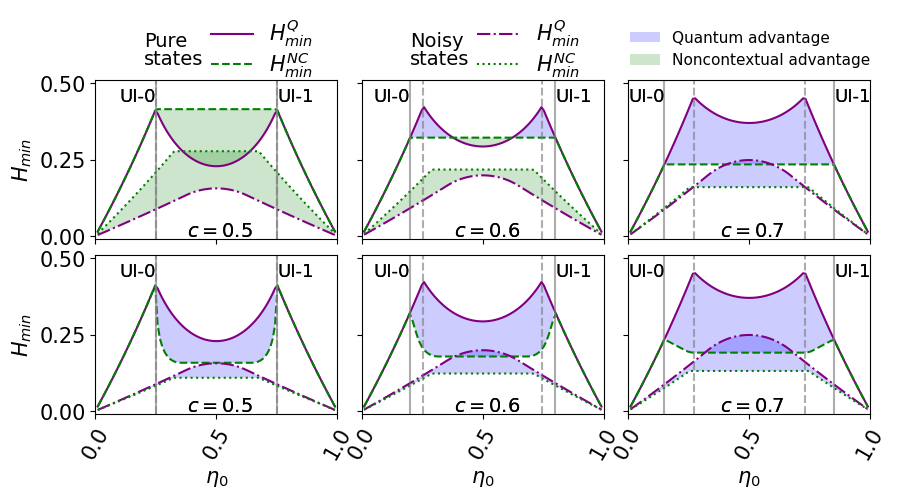

In [13]:
#Plot the results from the SDP
fig, ax = plt.subplots(2,3,figsize=(10,5.3),sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

plt.xticks([0.0,0.5,1.0])
plt.yticks([0.0,0.25,0.5])

plt.ylim(-0.01,0.51)
plt.xlim(0.,1.0)

ax[1,0].tick_params(axis='x', rotation=60)
ax[1,1].tick_params(axis='x', rotation=60)
ax[1,2].tick_params(axis='x', rotation=60)

ax[1,0].set_xlabel(r'$\eta_{0}$',size=15)
ax[1,1].set_xlabel(r'$\eta_{0}$',size=15)
ax[1,2].set_xlabel(r'$\eta_{0}$',size=15)
ax[1,0].set_ylabel(r'$H_{min}$',size=15)
ax[0,0].set_ylabel(r'$H_{min}$',size=15)

sel = []

for u in range(0,2):
    if u == 0:
        style_0 = '-'
        style_1 = '--'
    else:
        style_0 = '-.'
        style_1 = 'dotted'
        
    for j in range(1,4):
        
        if u == 0:

            pureq0 = ax[0,j-1].plot(eta1vec,Hminvec[u][0][j],label=r'$H_{min}^{Q}$',ls=style_0,c='purple')
            noisq0 = ax[0,j-1].plot(eta1vec,HminvecNC[u][0][j],label=r'$H_{min}^{NC}$',ls=style_1,c='green')

            puren0 = ax[1,j-1].plot(eta1vec,Hminvec[u][0][j],label=r'$H_{min}^{Q}$',ls=style_0,c='purple')
            noisn0 = ax[1,j-1].plot(eta1vec,Hminvec[u][1][j],label=r'$H_{min}^{NC}$',ls=style_1,c='green')
        
        else:

            pureq1 = ax[0,j-1].plot(eta1vec,Hminvec[u][0][j],label=r'$H_{min}^{Q}$',ls=style_0,c='purple')
            noisq1 = ax[0,j-1].plot(eta1vec,HminvecNC[u][0][j],label=r'$H_{min}^{NC}$',ls=style_1,c='green')

            puren1 = ax[1,j-1].plot(eta1vec,Hminvec[u][0][j],label=r'$H_{min}^{Q}$',ls=style_0,c='purple')
            noisn1 = ax[1,j-1].plot(eta1vec,Hminvec[u][1][j],label=r'$H_{min}^{NC}$',ls=style_1,c='green')

        qad = ax[0,j-1].fill_between(eta1vec, Hminvec[u][0][j], HminvecNC[u][0][j], where=Hminvec[u][0][j] >= HminvecNC[u][0][j], facecolor='blue', alpha=0.2)
        ncad = ax[0,j-1].fill_between(eta1vec, Hminvec[u][0][j], HminvecNC[u][0][j], where=Hminvec[u][0][j] <= HminvecNC[u][0][j], facecolor='green', alpha=0.2)

        qad = ax[1,j-1].fill_between(eta1vec, Hminvec[u][1][j], Hminvec[u][0][j], where=Hminvec[u][0][j] >= Hminvec[u][1][j], facecolor='blue', alpha=0.2)
        ncad = ax[1,j-1].fill_between(eta1vec, Hminvec[u][1][j], Hminvec[u][0][j], where=Hminvec[u][0][j] <= Hminvec[u][1][j], facecolor='green', alpha=0.2)

        for i in range(0,2):

            ax[i,j-1].text((1.0/2.0)*(1.0-olaps[j])-0.15,0.44,'UI-0',size=13,rotation=0)
            ax[i,j-1].text((1.0/2.0)*(1.0+olaps[j])+0.0,0.44,'UI-1',size=13,rotation=0)

            ax[i,j-1].text(0.38,0.,r'$c=$%1.1f' %olaps[j],size=14,rotation=0)

            ax[i,j-1].axvline((1.0/2.0)*(1.0-np.sqrt((1.0-olaps[j])*olaps[j])),c='gray',ls='--', alpha=0.4)
            ax[i,j-1].axvline((1.0/2.0)*(1.0+np.sqrt((1.0-olaps[j])*olaps[j])),c='gray',ls='--', alpha=0.4)

            ax[i,j-1].axvline((1.0/2.0)*(1.0-olaps[j]),c='gray',ls='-', alpha=0.4)
            ax[i,j-1].axvline((1.0/2.0)*(1.0+olaps[j]),c='gray',ls='-', alpha=0.4)


ax[0,0].text(0.2,0.62,'Pure',size=14)
ax[0,0].text(0.2,0.56,'states',size=14)

ax[0,0].text(1.3,0.62,'Noisy',size=14)
ax[0,0].text(1.3,0.56,'states',size=14)

ax[0,1].legend(handles=pureq0,bbox_to_anchor=(-0.7, 1.51), loc='upper left', ncol = 1, frameon=False)
ax[1,1].legend(handles=noisn0,bbox_to_anchor=(-0.7, 2.41), loc='upper left', ncol = 1, frameon=False)

ax[0,2].legend(handles=pureq1,bbox_to_anchor=(-0.7, 1.51), loc='upper left', ncol = 1, frameon=False)
ax[1,0].legend(handles=noisn1,bbox_to_anchor=(1.5, 2.41), loc='upper left', ncol = 1, frameon=False)


#ax[1,1].legend( bbox_to_anchor=(-1.2, 2.4), loc='upper left', ncol = 2, frameon=False)
ax[1,2].legend([qad,ncad], ['Quantum advantage', 'Noncontextual advantage'], bbox_to_anchor=(-0.05, 2.5), loc='upper left', ncol = 1, fontsize=11, frameon=False)
plt.gcf().subplots_adjust(bottom=0.25)

#plt.tight_layout()
plt.savefig('Dual_All_noisy_comp_big.pdf')
plt.show()

In [10]:
import numpy as np
epsilon = 10.0**(-9.0)
delta = 0.001
print(np.log(1.0/epsilon)/(2.0*delta**2.0))

10361632.918473208


In [11]:
print(int(np.log10(epsilon)))

-9
